In [1]:
%matplotlib inline
from edward.util import Progbar
import tensorflow as tf
from utils import (generator_xy, visulize, accuracy, 
                  NN_classifier)
import keras
import edward as ed
import numpy as np
from observations import mnist
import matplotlib.pyplot as plt
from edward.models import Normal, Bernoulli, Categorical
import pickle
import seaborn as sns
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
sess = tf.InteractiveSession()
ed.set_seed(100)
M = 12000
num_latent = 32
num_hidden = 16
D = 28*28
num_class = 10
(x_train, y_train), (x_test, y_test) = mnist('./data')
y_train = tf.cast(y_train, tf.int32).eval()
y_test = tf.cast(y_test, tf.int32).eval()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train_generator = generator_xy([x_train,y_train], M)

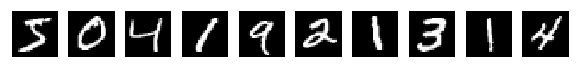

In [3]:
visulize(10, x_train)

In [4]:

def auto_encoder(x, W_encode, W_decode, b_endoce, b_decode):
    h = tf.nn.relu(tf.matmul(x,W_encode) + b_encode)
    h = tf.nn.sigmoid(tf.matmul(h,W_decode) + b_decode)
    return h


def encoder(x, W_encode, b_encode):
    h = tf.matmul(x,W_encode) + b_encode
    return h


In [5]:
W_encode = Normal(loc = tf.zeros([D, num_latent]), scale = 0.01 * tf.ones([D, num_latent]))
W_decode = Normal(loc = tf.zeros([num_latent, D]), scale = 0.01 * tf.ones([num_latent,D]))
b_encode = Normal(loc = tf.zeros(num_latent), scale = 0.01 * tf.ones(num_latent))
b_decode = Normal(loc = tf.zeros(D), scale = 0.01 * tf.ones(D))
W_clf_1  = Normal(loc = tf.zeros([num_latent, num_hidden]), scale = tf.ones([num_latent, num_hidden]))
b_clf_1  = Normal(loc = tf.zeros(num_hidden), scale = tf.ones(num_hidden)) 
W_clf_2  = Normal(loc = tf.zeros([num_hidden,num_class]), scale = tf.ones([num_hidden, num_class]))
b_clf_2  = Normal(loc = tf.zeros(num_class), scale = tf.ones(num_class))


x = tf.placeholder(tf.float32, [None, D])

x_reconstruct = Normal(loc=auto_encoder(x, W_encode, W_decode, b_encode, b_decode),
                      scale = 0.1 *tf.ones([D]))
y = Categorical(logits = NN_classifier(encoder(x, W_encode, b_encode) 
                             , W_clf_1, W_clf_2, b_clf_1, b_clf_2))

In [6]:
qW_encode = Normal(loc = tf.Variable(tf.random_normal([D,num_latent])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([D,num_latent]))))
qW_decode = Normal(loc = tf.Variable(tf.random_normal([num_latent ,D])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_latent,D]))))
qb_encode = Normal(loc = tf.Variable(tf.random_normal([num_latent])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_latent]))))
qb_decode = Normal(loc = tf.Variable(tf.random_normal([D])),
                   scale = tf.nn.softplus(tf.Variable(tf.random_normal([D]))))

qW_clf_1 = Normal(loc = tf.Variable(tf.random_normal([num_latent,num_hidden])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_latent,num_hidden]))))
qW_clf_2 = Normal(loc = tf.Variable(tf.random_normal([num_hidden,num_class])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_hidden,num_class]))))
qb_clf_1 = Normal(loc = tf.Variable(tf.random_normal([num_hidden])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_hidden]))))
qb_clf_2 = Normal(loc = tf.Variable(tf.random_normal([num_class])),
                   scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_class]))))



In [7]:
reconstruct = tf.stack([auto_encoder(x,qW_encode.sample(), 
                                   qW_decode.sample(), qb_encode.sample(), 
                                   qb_decode.sample()) 
                          for _ in range(4)])
tf.global_variables_initializer().run()
out = sess.run(reconstruct, feed_dict = {x: x_train})


(4, 60000, 784)


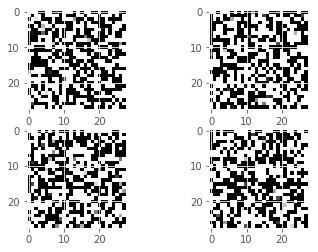

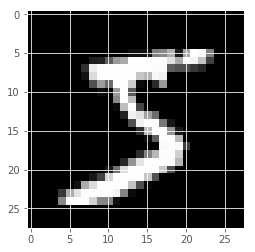

In [8]:
print(out.shape)
f, axes = plt.subplots(2, 2)
for ax, i in zip(axes.flat[0:], range(4)):
    ax.imshow(out[i,0,:].reshape(28,28),cmap = 'gray')
plt.show()
plt.imshow(x_train[0,:].reshape(28, 28), cmap = 'gray')
plt.show()

In [9]:
inference = ed.KLqp({W_encode:qW_encode, b_encode:qb_encode,
                    W_decode:qW_decode, b_decode:qb_decode, 
                    W_clf_1: qW_clf_1, W_clf_2: qW_clf_2, 
                    b_clf_1: qb_clf_1, b_clf_2: qb_clf_2}, 
                    data = {x: x_train, x_reconstruct: x_train, 
                           y: y_train})
inference.initialize(n_iter = 1000, n_samples = 5)
tf.global_variables_initializer().run()


In [10]:
n_epoch = 50
n_iter_per_epoch = x_train.shape[0] // M
log_loss = []
for epoch in range(1, n_epoch + 1):
  print("Epoch: {0}".format(epoch))
  avg_loss = 0.0

  pbar = Progbar(n_iter_per_epoch, verbose = 0)
  for t in range(1, n_iter_per_epoch + 1):
    pbar.update(t)
    x_batch, y_batch = next(x_train_generator)
    info_dict = inference.update(feed_dict={x: x_batch, x_reconstruct: x_batch, 
                                           y: y_batch})
    avg_loss += info_dict['loss']
  avg_loss = avg_loss / n_iter_per_epoch
  avg_loss = avg_loss / M
  log_loss.append(avg_loss)
  print("-log p(x) <= {:0.3f}".format(avg_loss))
    

Epoch: 1
-log p(x) <= 94952.614
Epoch: 2
-log p(x) <= 48365.058
Epoch: 3
-log p(x) <= 38852.945
Epoch: 4
-log p(x) <= 34551.929
Epoch: 5
-log p(x) <= 31123.153
Epoch: 6
-log p(x) <= 28226.697
Epoch: 7
-log p(x) <= 25947.471
Epoch: 8
-log p(x) <= 24168.601
Epoch: 9
-log p(x) <= 22625.225
Epoch: 10
-log p(x) <= 21480.770
Epoch: 11
-log p(x) <= 20561.511
Epoch: 12
-log p(x) <= 19779.463
Epoch: 13
-log p(x) <= 19036.766
Epoch: 14
-log p(x) <= 18227.649
Epoch: 15
-log p(x) <= 17359.804
Epoch: 16
-log p(x) <= 15964.366
Epoch: 17
-log p(x) <= 13729.583
Epoch: 18
-log p(x) <= 11843.069
Epoch: 19
-log p(x) <= 10782.135
Epoch: 20
-log p(x) <= 9548.327
Epoch: 21
-log p(x) <= 8483.080
Epoch: 22
-log p(x) <= 7324.893
Epoch: 23
-log p(x) <= 6269.564
Epoch: 24
-log p(x) <= 5568.953
Epoch: 25
-log p(x) <= 4922.873
Epoch: 26
-log p(x) <= 4216.706
Epoch: 27
-log p(x) <= 3891.149
Epoch: 28
-log p(x) <= 4336.295
Epoch: 29
-log p(x) <= 3703.768
Epoch: 30
-log p(x) <= 3504.938
Epoch: 31
-log p(x) <= 3236.57

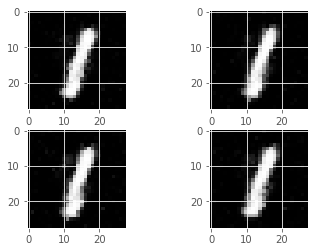

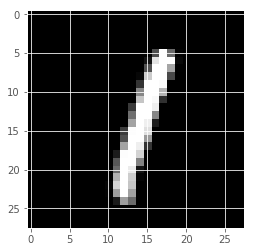

In [11]:
out = sess.run(reconstruct, feed_dict={x: x_test})
f, axes = plt.subplots(2, 2)
for ax, i in zip(axes.flat[0:], range(4)):
    ax.imshow(out[i,5,:].reshape(28,28),cmap = 'gray')
plt.show()
plt.imshow(x_test[5,:].reshape(28, 28), cmap = 'gray')
plt.show()

In [12]:
encode_weights = qW_encode.sample()
encode_bias = qb_encode.sample()
train_encoded = tf.matmul(x_train, encode_weights) + encode_bias
test_encoded = tf.matmul(x_test, encode_weights) + encode_bias
# with open('./data/encoded_train_BAE.pkl','wb') as f:
#     pickle.dump(train_encoded.eval(),f)
# with open('./data/encoded_test_BAE.pkl','wb') as f:
#     pickle.dump(test_encoded.eval(),f)

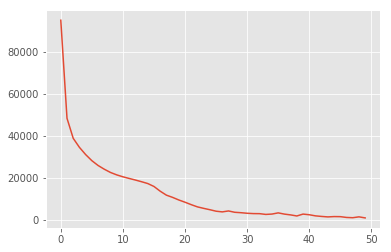

In [13]:
plt.plot(range(50), log_loss)
plt.show()